In [1]:
import tensorflow as tf
import os
import numpy as np
import warnings
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

tf.keras.backend.clear_session()

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [2]:
def build_train_data_generator(train_images_path = "D:/GitHub/Datasets/MassachusettsRoads/Train/Images",
                               train_masks_path = "D:/GitHub/Datasets/MassachusettsRoads/Train/Masks",
                               batch_size = 16,
                               seed = 42,
                               target_size = (256, 256)):

    data_generator_args = dict(featurewise_center = False,
                               samplewise_center = False,
                               featurewise_std_normalization = False,
                               samplewise_std_normalization = False,
                               zca_whitening = False, 
                               zca_epsilon = 1e-06,
                               rotation_range = 90, 
                               width_shift_range = 0.0,
                               height_shift_range = 0.0, 
                               brightness_range = None, 
                               shear_range = 0.0, 
                               zoom_range = 0.0, 
                               channel_shift_range = 0.0,
                               fill_mode = 'nearest', 
                               cval = 0.0,
                               horizontal_flip = True,
                               vertical_flip = True, 
                               rescale = 1/255,
                               preprocessing_function = None,
                               data_format = None,
                               validation_split = 0.0,
                               dtype = None)

    image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_generator_args)
    mask_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_generator_args)

    image_data_generator_ = image_data_generator.flow_from_directory(
            train_images_path,
            batch_size = batch_size,
            target_size = target_size, 
            shuffle = True,
            seed = seed)

    mask_data_generator_ = mask_data_generator.flow_from_directory(
            train_masks_path,
            batch_size = batch_size,
            target_size = target_size, 
            shuffle = True,
            seed = seed)

    train_generator = zip(image_data_generator_, mask_data_generator_)
    
    return train_generator

def build_validation_data_generator(validation_images_path = "D:/GitHub/Datasets/MassachusettsRoads/Validation/Images",
                                    validation_masks_path = "D:/GitHub/Datasets/MassachusettsRoads/Validation/Masks",
                                    batch_size = 16,
                                    seed = 42,
                                    target_size = (256, 256)):

    data_generator_args = dict(featurewise_center = False,
                               samplewise_center = False,
                               featurewise_std_normalization = False,
                               samplewise_std_normalization = False,
                               zca_whitening = False, 
                               zca_epsilon = 1e-06,
                               rotation_range = 0, 
                               width_shift_range = 0.0,
                               height_shift_range = 0.0, 
                               brightness_range = None, 
                               shear_range = 0.0, 
                               zoom_range = 0.0, 
                               channel_shift_range = 0.0,
                               fill_mode = 'nearest', 
                               cval = 0.0,
                               horizontal_flip = False,
                               vertical_flip = False, 
                               rescale = 1/255,
                               preprocessing_function = None,
                               data_format = None,
                               validation_split = 0.0,
                               dtype = None)

    image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_generator_args)
    mask_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(**data_generator_args)

    image_data_generator_ = image_data_generator.flow_from_directory(
        validation_images_path,
        batch_size = batch_size,
        target_size = target_size, 
        shuffle = True,
        seed = seed)

    mask_data_generator_ = mask_data_generator.flow_from_directory(
        validation_masks_path,
        batch_size = batch_size,
        target_size = target_size, 
        shuffle = True,
        seed = seed)

    validation_generator = zip(image_data_generator_, mask_data_generator_)
    
    return validation_generator

In [3]:
def unet_model(input_size = (256, 256, 3), mult = 1, dropout = 0.1):
    
    inputs = tf.keras.layers.Input(input_size)
    
    # inputs = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    
    c1 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Dropout(dropout)(c1)
    c1 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Dropout(dropout)(c2)
    c2 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Dropout(dropout)(c3)
    c3 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    p3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Dropout(dropout)(c4)
    c4 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(filters = 256 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Dropout(dropout)(c5)
    c5 = tf.keras.layers.Conv2D(filters = 256 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)

    u6 = tf.keras.layers.Conv2DTranspose(filters = 128 * mult, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4], axis = 3)
    c6 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Dropout(dropout)(c6)
    c6 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)

    u7 = tf.keras.layers.Conv2DTranspose(filters = 64 * mult, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3], axis = 3)
    c7 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Dropout(dropout)(c7)
    c7 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)

    u8 = tf.keras.layers.Conv2DTranspose(filters = 32 * mult, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2], axis = 3)
    c8 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Dropout(dropout)(c8)
    c8 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)

    u9 = tf.keras.layers.Conv2DTranspose(filters = 16 * mult, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
    c9 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Dropout(dropout)(c9)
    c9 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)

    outputs = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1, 1), activation = 'sigmoid')(c9)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    # print(model.summary())

    return model

In [4]:
model = unet_model(input_size = (256, 256, 3), mult = 1, dropout = 0.1)
model.compile(optimizer = "adam",
              loss = "binary_crossentropy")

In [5]:
batch_size = 32
train_generator = build_train_data_generator(batch_size = batch_size)
validation_generator = build_validation_data_generator(batch_size = batch_size)
steps_train = np.ceil(len(os.listdir("D:/GitHub/Datasets/MassachusettsRoads/Train/Images/Images"))/batch_size)
steps_validation = np.ceil(len(os.listdir("D:/GitHub/Datasets/MassachusettsRoads/Validation/Images/Images"))/batch_size)

Found 53028 images belonging to 1 classes.
Found 53028 images belonging to 1 classes.
Found 13257 images belonging to 1 classes.
Found 13257 images belonging to 1 classes.


In [6]:
epochs = 100
model_path = "D:/GitHub/Datasets/MassachusettsRoads/model_mult_1_256_crops.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                      monitor = "val_loss",
                                                      mode = "min",
                                                      save_best_only = True,
                                                      verbose = 2)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  min_delta = 0, 
                                                  patience = np.ceil(epochs * 0.05),
                                                  verbose = 2,
                                                  restore_best_weights = True)

history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              steps_per_epoch = steps_train,
                              validation_steps = steps_validation,
                              epochs = epochs,
                              callbacks = [model_checkpoint, early_stopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1658/1658 [==============================] - ETA: 0s - loss: 0.1554
Epoch 00001: val_loss improved from inf to 0.08905, saving model to D:/GitHub/Datasets/MassachusettsRoads\model_mult_1_256_crops.h5
1658/1658 [==============================] - 1379s 832ms/step - loss: 0.1554 - val_loss: 0.0891
Epoch 2/100
1657/1658 [============================>.] - ETA: 0s - loss: 0.0873
Epoch 00002: val_loss improved from 0.08905 to 0.08376, saving model to D:/GitHub/Datasets/MassachusettsRoads\model_mult_1_256_crops.h5
1658/1658 [==============================] - 1446s 872ms/step - loss: 0.0873 - val_loss: 0.0838
Epoch 3/100
1657/1658 [============================>.] - ETA: 0s - loss: 0.0812
Epoch 00003: val_loss improved from 0.08376 to 0.07387, saving model to D:/GitHub/Datasets/MassachusettsRoads\model_mult_1_256_crops.h5
1658/1658 [==============================] - 1190s 717ms/step - loss: 0.0813 - val_loss:

In [60]:
tf.keras.backend.clear_session()
model = unet_model(input_size = (256, 256, 3), mult = 1)
model.load_weights("D:/GitHub/Datasets/MassachusettsRoads/model_mult_1_256_crops.h5")
model.compile(optimizer = "adam",
              loss = "binary_crossentropy")

0 0 1 0 256 0 256
0 1 2 0 256 256 512
0 2 3 0 256 512 768
0 3 4 0 256 768 1024
1 0 5 256 512 0 256
1 1 6 256 512 256 512
1 2 7 256 512 512 768
1 3 8 256 512 768 1024
2 0 9 512 768 0 256
2 1 10 512 768 256 512
2 2 11 512 768 512 768
2 3 12 512 768 768 1024
3 0 13 768 1024 0 256
3 1 14 768 1024 256 512
3 2 15 768 1024 512 768
3 3 16 768 1024 768 1024


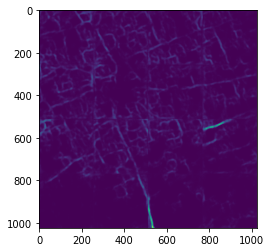

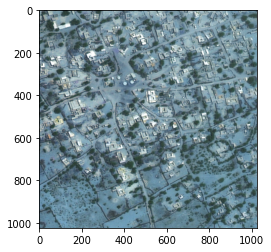

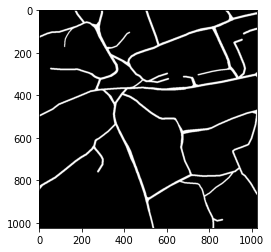

In [232]:
tf.keras.backend.clear_session()

dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
images = os.path.join(dataset_path, "Images_All")
masks = os.path.join(dataset_path, "Masks_All")

id = 156 # 1000, 2000
#id = 500
image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

if image.shape[0] == 1024:
    rows = 4
if image.shape[0] == 1500:
    rows = 6
    
if image.shape[1] == 1024:
    cols = 4
if image.shape[1] == 1500:
    cols = 6
    
if rows == 6 & cols == 6:
    image = cv2.resize(image, (rows * 256, cols * 256), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (rows * 256, cols * 256), interpolation = cv2.INTER_NEAREST)
    
rows_ = np.round(image.shape[0]/rows)
rows_indices = [0]

for i in np.arange(0, rows):
    if i < rows - 1:
        rows_indices.append(int((i + 1) * rows_))
    else:
        rows_indices.append(int(image.shape[0]))
        
rows_indices

cols_ = np.round(image.shape[1]/cols)
cols_indices = [0]

for i in np.arange(0, cols):
    if i < cols - 1:
        cols_indices.append(int((i + 1) * cols_))
    else:
        cols_indices.append(int(image.shape[1]))
        
images_ = []
masks_ = []

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]
        
        image_ = image[i_start:i_end, j_start:j_end, :]
        images_.append(image_)
        images__ = np.array(images_)
        images__ = images__/255
        mask_ = mask[i_start:i_end, j_start:j_end, :]
        masks_.append(mask_)
        masks__ = np.array(masks_)
    
prediction_output = np.zeros((image.shape[0], image.shape[1], 1))

prediction = model.predict(images__) * 255

width = len(rows_indices) - 1

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]
        
        print(i, j, (i * width) + (j + 1), i_start, i_end, j_start, j_end)
        prediction_output[i_start:i_end, j_start:j_end, :] = prediction[(i * width) + (j + 1) - 1,:, :, :] 
        
        #prediction_output *= 255.0/prediction_output.max() 

plt.imshow(prediction_output)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

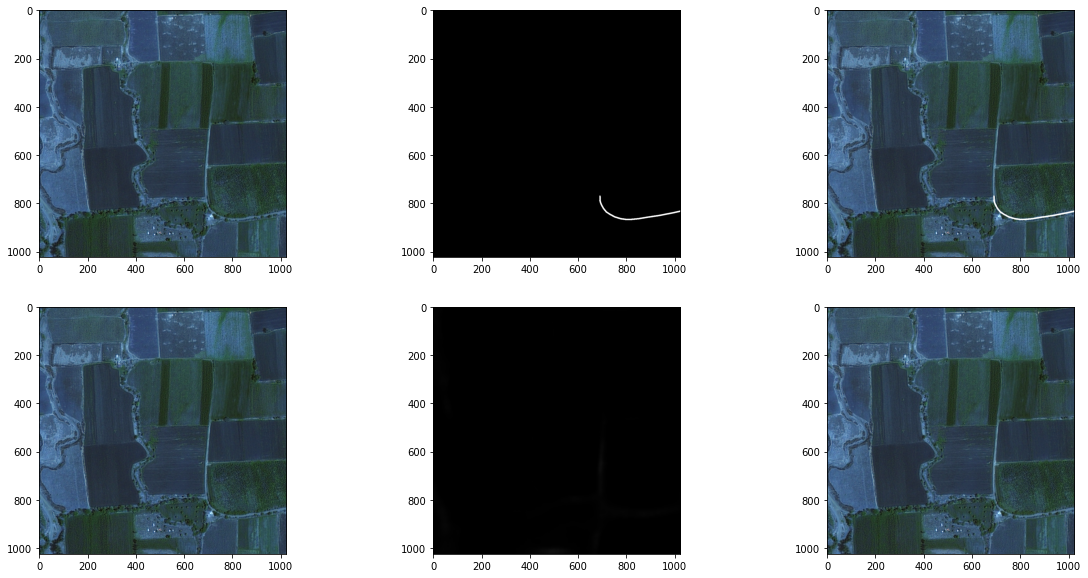

In [227]:
dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
# images = os.path.join(dataset_path, "Images_Crops_Verified")
# masks = os.path.join(dataset_path, "Masks_Crops_Verified")
images = os.path.join(dataset_path, "Images_All")
masks = os.path.join(dataset_path, "Masks_All")

id = 1856
background = cv2.imread(os.path.join(images, os.listdir(images)[id]))
overlay_true = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))
shape_1, shape_2, shape_3 = background.shape
img = tf.keras.preprocessing.image.load_img(os.path.join(images, os.listdir(images)[id]), target_size = (256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img = img * 1/255
predicted = model.predict(img)

# cutoff = 0.25
# predicted[predicted > cutoff] = 1.0
# predicted[predicted <= cutoff] = 0.0

overlay_prediction = np.squeeze(predicted, axis = 0)
overlay_prediction = overlay_prediction * 255
overlay_prediction = np.concatenate([overlay_prediction, overlay_prediction, overlay_prediction], axis = -1)
overlay_prediction = cv2.resize(overlay_prediction, dsize = (shape_1, shape_2), interpolation = cv2.INTER_LINEAR)
overlay_prediction = np.asarray(overlay_prediction, np.uint8)

added_image_true = cv2.addWeighted(background, 1, overlay_true, 1, 1)
added_image_prediction = cv2.addWeighted(background, 1, overlay_prediction, 1, 1)

fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(background)
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(overlay_true)
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(added_image_true)
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(background)
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(overlay_prediction)
ax5 = fig.add_subplot(2, 3, 6)
ax5.imshow(added_image_prediction)

5


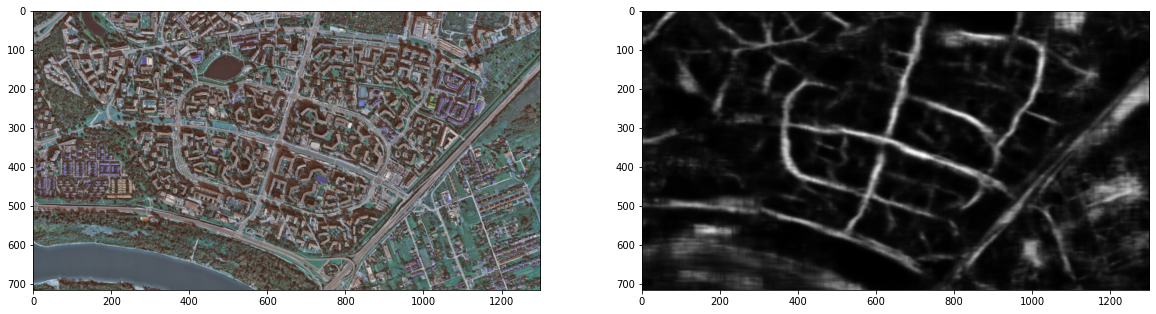

In [14]:
filename = "test_11.png" # test_2, test_4, test_5, test_7, test_11
image = cv2.imread(os.path.join("D:/GitHub/Datasets/MassachusettsRoads/", filename))

# id = 10
# dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
# images = os.path.join(dataset_path, "Images")
# masks = os.path.join(dataset_path, "Masks")
# image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
# mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

shape_1, shape_2, shape_3 = image.shape

#sizes = [1500, 1250, 1000, 750, 500, 375, 300]
sizes = list(np.arange(1250, 1500, 50))
prediction_maps = []

for idx in np.arange(len(sizes)):
    
    if shape_1 // sizes[idx] == 0 and shape_2 // sizes[idx] == 0:
        
        img = cv2.resize(image, dsize = (256, 256), interpolation = cv2.INTER_LINEAR)
        img = np.expand_dims(img, axis = 0)
        img = img * 1/255
        img = model.predict(img)
        img = np.squeeze(img, axis = 0)
        img = cv2.resize(img, dsize = (shape_2, shape_1), interpolation = cv2.INTER_LINEAR)
        img_end = np.expand_dims(img, axis = -1)
        prediction_maps.append(img_end)
        
    else:
        
        rows = (shape_1 // sizes[idx]) + 1
        cols = (shape_2 // sizes[idx]) + 1

        img_base = np.ones(shape = (rows * sizes[idx], cols * sizes[idx], 3))
        img_base = np.asarray(img_base, image.dtype)
        img_end = np.ones(shape = (img_base.shape[0], img_base.shape[1], 1))

        img_base[:shape_1, :shape_2, :] = image

        rows_indices = [0]
        rows_ = np.round(img_base.shape[0]/rows)
        for i in np.arange(0, rows):
            if i < rows - 1:
                rows_indices.append(int((i + 1) * rows_))
            else:
                rows_indices.append(int(img_base.shape[0]))

        cols_indices = [0]
        cols_ = np.round(img_base.shape[1]/cols)
        for i in np.arange(0, cols):
            if i < cols - 1:
                cols_indices.append(int((i + 1) * cols_))
            else:
                cols_indices.append(int(img_base.shape[1]))

        for i in np.arange(len(rows_indices) - 1):

            i_start = rows_indices[i]
            i_end = rows_indices[i + 1]

            for j in np.arange(len(cols_indices) - 1):

                j_start = cols_indices[j]
                j_end = cols_indices[j + 1]

                img = img_base[i_start:i_end, j_start:j_end, :]
                img = cv2.resize(img, dsize = (256, 256), interpolation = cv2.INTER_LINEAR)
                img = np.expand_dims(img, axis = 0)
                img = img * 1/255
                img = model.predict(img)
                img = np.squeeze(img, axis = 0)
                img = cv2.resize(img, dsize = (sizes[idx], sizes[idx]), interpolation = cv2.INTER_LINEAR)
                img = np.expand_dims(img, axis = -1)
                img_end[i_start:i_end, j_start:j_end, :] = img

        img_end = img_end[:shape_1, :shape_2, :]
        prediction_maps.append(img_end)

print(len(prediction_maps))

img_final = np.concatenate(prediction_maps, axis = -1)
img_final = np.sum(img_final, axis = -1)
img_final = np.expand_dims(img_final, axis = -1)
img_final = 255 * (img_final - np.min(img_final))/(np.max(img_final) - np.min(img_final))

fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img_final, cmap = 'gray')

5


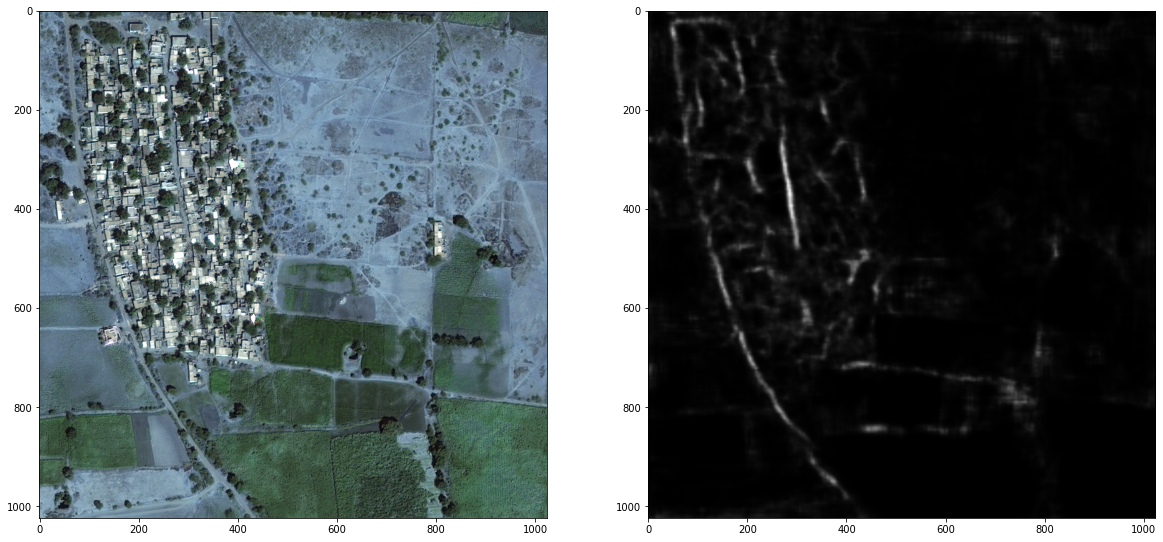

In [42]:
filename = "test_11.png" # test_2, test_4, test_5, test_7, test_11
files = [os.path.join(r"D:\GitHub\Datasets\DeepGlobe Road Extraction Dataset\test", i) for i in os.listdir(r"D:\GitHub\Datasets\DeepGlobe Road Extraction Dataset\test")]
id = 5
image = cv2.imread(files[id])

# id = 10
# dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
# images = os.path.join(dataset_path, "Images")
# masks = os.path.join(dataset_path, "Masks")
# image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
# mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

shape_1, shape_2, shape_3 = image.shape

#sizes = [1500, 1250, 1000, 750, 500, 375, 300]
sizes = list(np.arange(1250, 1500, 50))
prediction_maps = []

for idx in np.arange(len(sizes)):
    
    if shape_1 // sizes[idx] == 0 and shape_2 // sizes[idx] == 0:
        
        img = cv2.resize(image, dsize = (256, 256), interpolation = cv2.INTER_LINEAR)
        img = np.expand_dims(img, axis = 0)
        img = img * 1/255
        img = model.predict(img)
        img = np.squeeze(img, axis = 0)
        img = cv2.resize(img, dsize = (shape_2, shape_1), interpolation = cv2.INTER_LINEAR)
        img_end = np.expand_dims(img, axis = -1)
        prediction_maps.append(img_end)
        
    else:
        
        rows = (shape_1 // sizes[idx]) + 1
        cols = (shape_2 // sizes[idx]) + 1

        img_base = np.ones(shape = (rows * sizes[idx], cols * sizes[idx], 3))
        img_base = np.asarray(img_base, image.dtype)
        img_end = np.ones(shape = (img_base.shape[0], img_base.shape[1], 1))

        img_base[:shape_1, :shape_2, :] = image

        rows_indices = [0]
        rows_ = np.round(img_base.shape[0]/rows)
        for i in np.arange(0, rows):
            if i < rows - 1:
                rows_indices.append(int((i + 1) * rows_))
            else:
                rows_indices.append(int(img_base.shape[0]))

        cols_indices = [0]
        cols_ = np.round(img_base.shape[1]/cols)
        for i in np.arange(0, cols):
            if i < cols - 1:
                cols_indices.append(int((i + 1) * cols_))
            else:
                cols_indices.append(int(img_base.shape[1]))

        for i in np.arange(len(rows_indices) - 1):

            i_start = rows_indices[i]
            i_end = rows_indices[i + 1]

            for j in np.arange(len(cols_indices) - 1):

                j_start = cols_indices[j]
                j_end = cols_indices[j + 1]

                img = img_base[i_start:i_end, j_start:j_end, :]
                img = cv2.resize(img, dsize = (256, 256), interpolation = cv2.INTER_LINEAR)
                img = np.expand_dims(img, axis = 0)
                img = img * 1/255
                img = model.predict(img)
                img = np.squeeze(img, axis = 0)
                img = cv2.resize(img, dsize = (sizes[idx], sizes[idx]), interpolation = cv2.INTER_LINEAR)
                img = np.expand_dims(img, axis = -1)
                img_end[i_start:i_end, j_start:j_end, :] = img

        img_end = img_end[:shape_1, :shape_2, :]
        prediction_maps.append(img_end)

print(len(prediction_maps))

img_final = np.concatenate(prediction_maps, axis = -1)
img_final = np.sum(img_final, axis = -1)
img_final = np.expand_dims(img_final, axis = -1)
img_final = 255 * (img_final - np.min(img_final))/(np.max(img_final) - np.min(img_final))

fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img_final, cmap = 'gray')